In [3]:
import heapq
import math

import utils
from Core.PRef import PRef
import numpy as np


class SPRef:
    sessions: list[set[int]]
    fitnesses: np.ndarray
    
    def __init__(self,
                 sessions: list[set[int]],
                 fitnesses: np.ndarray):
        self.sessions = sessions
        self.fitnesses = fitnesses
        
        
    @classmethod
    def from_pRef(cls, pRef: PRef):
        def row_to_set(row):
            return {index for index, value in enumerate(row) if value}
        return cls(list(map(row_to_set, pRef.full_solution_matrix)), pRef.fitness_array)

    def get_matching_fitnesses_and_not_matching(self, ps: set[int], threshold: float):
        if len(ps) < threshold:
            return np.array([]), self.fitnesses  # shortcut
        
        most_leftover = len(ps) - threshold
        matches = []
        non_matches = []
        
        for session, fitness in zip(self.sessions, self.fitnesses):
            if len(ps-session) <= most_leftover:
                matches.append(fitness)
            else:
                non_matches.append(fitness)
        return np.array(matches), np.array(non_matches)
    
    
    
class OptimisedSPref(SPRef):
    which_sessions: list[set[int]]
    
    def __init__(self, sessions: list[set[int]],
                 fitnesses: np.ndarray):
        super().__init__(sessions, fitnesses)
        
        max_product = max(product  for session in self.sessions
                                 for product in session)
        self.which_sessions = [{index for index, session in enumerate(sessions)
                                if product in session}
                               for product in range(max_product+1)]
        
    
    def get_matching_fitnesses_and_not_matching(self, ps: set[int], threshold: float):
        if len(ps) < threshold:
            return np.array([]), self.fitnesses  # shortcut
        
        most_leftover = len(ps) - threshold
        index_matches = set()
        possible_session_indices = set.union(*(self.which_sessions[product] for product in ps))
        index_non_matches = set(range(len(self.sessions))) - possible_session_indices
        
        for index in possible_session_indices:
            session = self.sessions[index]
            if len(ps-session) <= most_leftover:
                index_matches.add(index)
            else:
                index_non_matches.add(index)
                
        return np.array(self.fitnesses[list(index_matches)]), np.array(self.fitnesses[list(index_non_matches)])
        
    
    def get_matching_fitnesses(self, ps: set[int], threshold: float):
        return self.get_matching_fitnesses_and_not_matching(ps, threshold)[0]
    
    


In [4]:
from Gian_experimental.NSGAIICustom.NSGAIICustom import NCSolution
from scipy.stats import mannwhitneyu, ttest_ind
import itertools


def complexity(ps):
    return len(ps)

def make_mean_fitness(sPRef: SPRef, threshold: float = 0.5):
    global_average = np.average(sPRef.fitnesses)
    terrible = np.min(sPRef.fitnesses)
    def mean_fitness(ps):
        if len(ps) == 0:
            return global_average  # shortcut
        match_fitnesses = sPRef.get_matching_fitnesses(ps, threshold=threshold)
        if len(match_fitnesses) > 0:
            return np.average(match_fitnesses)
        else:
            return terrible
        
    return mean_fitness


def make_similarity_atomicity(similarities):
    def atomicity(ps):
        if len(ps) < 2:
            return -1000
        else:
            linkages = [similarities[a, b] for a, b in itertools.combinations(ps, r=2)]
            return np.average(linkages)
    return atomicity



def permutation_mannwhitney_u(group1, group2, alternative="greater", n_permutations=10000, random_state=None):
    """
    Perform a permutation-based Mann-Whitney U test.
    
    Parameters:
    - group1, group2: array-like samples.
    - alternative: "greater", "less", or "two-sided".
    - n_permutations: number of random permutations.
    - random_state: seed or numpy Generator.
    
    Returns:
    - U_obs: observed U statistic.
    - p_value: empirical p-value.
    """
    group1 = np.asarray(group1)
    group2 = np.asarray(group2)
    n1, n2 = len(group1), len(group2)
    
    # Combine and rank once
    combined = np.concatenate([group1, group2])
    ranks = rankdata(combined)
    
    # Observed U for group1
    R1_obs = ranks[:n1].sum()
    U_obs = R1_obs - n1 * (n1 + 1) / 2
    
    # Permutation
    rng = np.random.default_rng(random_state)
    idx = np.arange(n1 + n2)
    count = 0
    for _ in range(n_permutations):
        perm = rng.permutation(idx)
        R1 = ranks[perm[:n1]].sum()
        U = R1 - n1 * (n1 + 1) / 2
        
        if alternative == "greater" and U >= U_obs:
            count += 1
        elif alternative == "less" and U <= U_obs:
            count += 1
        elif alternative == "two-sided" and abs(U - n1*n2/2) >= abs(U_obs - n1*n2/2):
            count += 1
    
    p_value = (count + 1) / (n_permutations + 1)
    return p_value


def make_consistency_metric_with_sample_size(sPRef: SPRef, 
                            threshold: float = 0.5,
                            must_match_at_least: int = 3):
    def consistency_and_sample(ps):
        matches, non_matches = sPRef.get_matching_fitnesses_and_not_matching(ps, threshold=threshold)
        if min(len(matches), len(non_matches)) < must_match_at_least:
            return 1, len(matches)
        else:
            # test = mannwhitneyu(matches, non_matches, alternative="greater", method="asymptotic")
            test = ttest_ind(matches, non_matches, alternative="greater")
            return test.pvalue, len(matches)
            #return permutation_mannwhitney_u(matches, non_matches, n_permutations=50), len(matches)
    
    return consistency_and_sample


def make_min_metric_with_sample_size(sPRef: SPRef, 
                                    threshold: float = 0.5):
    def min_and_sample(ps):
        matches, non_matches = sPRef.get_matching_fitnesses_and_not_matching(ps, threshold=threshold)
        if  min(len(matches), len(non_matches)) < 1:
            return (-1000, len(matches))
        else:
            lowest_fitness = np.min(matches)
        return lowest_fitness, len(matches)
    
    return min_and_sample


import numpy as np
from scipy.stats import rankdata




class HashedSolution:
    solution: NCSolution
    
    def __init__(self,
                 sol):
        self.solution = sol
    
    def __hash__(self):
        return sum(self.solution) % 7787
    
    def __eq__(self, other):
        return self.solution == other.solution


def make_metrics_cached(metrics):
    cached_values = dict()
    def get_values(ps):
        wrapped = HashedSolution(ps)
        if wrapped in cached_values:
            return cached_values[wrapped]
        else:

            value = metrics(ps)
            cached_values[wrapped] = value
            return value
    return get_values
        
    

In [5]:
from PolishSystem.OperatorsBasedOnSimilarities.similarities_utils import gian_get_similarities
from PolishSystem.read_data import get_pRef_from_vectors
import os

dir_250 = r"C:\Users\gac8\PycharmProjects\PSSearch\data\retail_forecasting\250"
#dir_250 = r"/Users/gian/PycharmProjects/PSSearch/data/retail_forecasting/250"

def in_250(path):
    return os.path.join(dir_250, path)

train_pRef = get_pRef_from_vectors(name_of_vectors_file=in_250("train_many_hot_vectors_250_qmc.csv"),
                             name_of_fitness_file=in_250("train_fitness_250_qmc.csv"),
                             column_in_fitness_file=2)
test_pRef = get_pRef_from_vectors(name_of_vectors_file=in_250("test_many_hot_vectors_250_qmc.csv"),
                             name_of_fitness_file=in_250("test_fitness_250_qmc.csv"),
                             column_in_fitness_file=2)

cluster_info_file_name = in_250(f"cluster_info_250_qmc.pkl")
similarities = gian_get_similarities(cluster_info_file_name)

In [6]:
train_sPRef = SPRef.from_pRef(train_pRef)
test_sPRef = SPRef.from_pRef(test_pRef)


threshold = 3

train_mean_fitness = make_mean_fitness(train_sPRef, threshold=threshold)
train_atomicity = make_similarity_atomicity(similarities)
train_consistency_and_sample = make_consistency_metric_with_sample_size(train_sPRef, threshold=threshold, must_match_at_least=3)
train_min_and_sample = make_min_metric_with_sample_size(train_sPRef, threshold=threshold)




In [7]:


from PolishSystem.OperatorsBasedOnSimilarities.similarities_utils import get_transition_matrix
from typing import Iterable
from Gian_experimental.NSGAIICustom.NSGAIICustom import NSGAIICustom, NCSolution, NCSamplerSimple, NCMutationSimple, \
    NCCrossoverSimple, EvaluatedNCSolution, NCSamplerFromPRef, NCCrossoverTransition
import heapq

mf_m = make_mean_fitness(train_sPRef, threshold=3)

def get_metrics(ps: NCSolution) -> tuple[float]:
    #p_value, sample_size = train_consistency_and_sample(ps)
    if len(ps) == 0:
        return (1000, 1000, 1000)
    matching, non_matching = train_sPRef.get_matching_fitnesses_and_not_matching(ps, threshold=threshold)
    
    len_m, len_nm = len(matching), len(non_matching)
    quality = (np.var(matching)*len_m + np.var(non_matching)*len_nm) / (len_m+ len_nm)
    
    atomicity = train_atomicity(ps)
    
    return (-len(ps), quality, -atomicity)

n = 250

def keep_ones_with_most_samples(population: Iterable[EvaluatedNCSolution], quantity_required: int):
    return heapq.nsmallest(iterable=population, key=lambda x: x.fitnesses[0], n=quantity_required)


custom_sampling = NCSamplerFromPRef.from_PRef(train_pRef)
transition_matrix = get_transition_matrix(similarities)
custom_crossover = NCCrossoverTransition(similarities)

traditional_sampling = NCSamplerSimple.with_average_quantity(3, genome_size=n)
traditional_mutation = NCMutationSimple(n)

traditional_crossover = NCCrossoverSimple(swap_probability=1 / n)

algorithm = NSGAIICustom(sampling=custom_sampling,
                         mutation=traditional_mutation,
                         crossover=custom_crossover,
                         probability_of_crossover=0.5,
                         eval_budget=5000,
                         pop_size=100,
                         tournament_size=3,
                         mo_fitness_function=make_metrics_cached(get_metrics),
                         unique=True,
                         verbose=True,
                         culler=keep_ones_with_most_samples
                         )

In [8]:
if True:
    results = algorithm.run()
    
    for result in results:
        print(result)

NSGAIICustom -> Beginning of NC process


C:\Users\gac8\AppData\Local\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3747: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\gac8\AppData\Local\anaconda3\Lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\gac8\AppData\Local\anaconda3\Lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\gac8\PycharmProjects\PSSearch\PolishSystem\OperatorsBasedOnSimilarities\similarities_utils.py:61: RuntimeWarning: invalid value encountered in divide
  with_sum_one = vec / np.sum(vec)


NSGAIICustom -> Used evals: 209
NSGAIICustom -> Used evals: 325
NSGAIICustom -> Used evals: 436
NSGAIICustom -> Used evals: 536
NSGAIICustom -> Used evals: 641
NSGAIICustom -> Used evals: 747
NSGAIICustom -> Used evals: 851
NSGAIICustom -> Used evals: 957
NSGAIICustom -> Used evals: 1065
NSGAIICustom -> Used evals: 1168
NSGAIICustom -> Used evals: 1271
NSGAIICustom -> Used evals: 1371
NSGAIICustom -> Used evals: 1476
NSGAIICustom -> Used evals: 1577
NSGAIICustom -> Used evals: 1678
NSGAIICustom -> Used evals: 1780
NSGAIICustom -> Used evals: 1883
NSGAIICustom -> Used evals: 1983
NSGAIICustom -> Used evals: 2084
NSGAIICustom -> Used evals: 2185
NSGAIICustom -> Used evals: 2286
NSGAIICustom -> Used evals: 2387
NSGAIICustom -> Used evals: 2488
NSGAIICustom -> Used evals: 2589
NSGAIICustom -> Used evals: 2690
NSGAIICustom -> Used evals: 2790
NSGAIICustom -> Used evals: 2891
NSGAIICustom -> Used evals: 2992
NSGAIICustom -> Used evals: 3093
NSGAIICustom -> Used evals: 3195
NSGAIICustom -> Us

In [9]:
print(len(results))

good_results = [result for result in results
                if result.fitnesses[1] < 0.05
                if result.fitnesses[2] < 0]

results.sort(key=lambda x: x.fitnesses[0], reverse=True)
print([len(result.solution) for result in results])

70
[44, 50, 52, 53, 58, 63, 63, 64, 65, 66, 67, 69, 70, 72, 72, 72, 77, 78, 79, 79, 80, 81, 82, 83, 83, 83, 84, 85, 86, 88, 90, 90, 91, 92, 92, 96, 97, 98, 98, 99, 99, 99, 99, 99, 99, 100, 100, 101, 103, 103, 103, 104, 104, 104, 105, 105, 105, 106, 107, 108, 109, 109, 112, 113, 113, 115, 119, 121, 121, 121]


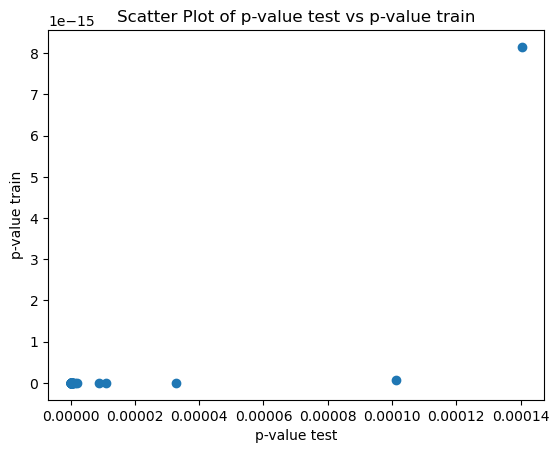

(True, True) 70


In [10]:
import utils
test_consistency_and_sample = make_consistency_metric_with_sample_size(test_sPRef, threshold=threshold, must_match_at_least=3)
train_consistency_and_sample = make_consistency_metric_with_sample_size(train_sPRef, threshold=threshold, must_match_at_least=3)
p_values_on_train = [train_consistency_and_sample(solution.solution)[0] for solution in results]
p_values_on_test = [test_consistency_and_sample(ps.solution)[0] for ps in results]



#print((p_values_on_test), (p_values_on_train))
# for ps in results:
#     p_value_train, sample_train = train_consistency_and_sample(ps.solution)
#     p_value_test, sample_test = test_consistency_and_sample(ps.solution)
#     
#     print(f"For ps of size {len(ps.solution)}, {sample_train/train_pRef.sample_size:.4f}, {sample_test/test_pRef.sample_size:.4f}")
utils.simple_scatterplot(xs=p_values_on_test, ys=p_values_on_train, x_label="p-value test", y_label="p-value train")

for item in results:
    ps = item.solution

def count_frequencies(iterable):
    iterable_list = list(iterable)
    counts = {item: iterable_list.count(item)
              for item in set(iterable)}
    
    for key, count in counts.items():
        print(key, count)



combinations = [(on_train < 0.05, on_test < 0.05) for on_train, on_test in zip(p_values_on_train, p_values_on_test)]

count_frequencies(combinations)

In [11]:
values = np.zeros(250)

for ps in results:
    for value in ps.solution:
        values[value] += 1
        

freqs = values/len(results)
print(freqs[list(results[0].solution)])
# for index, value in enumerate(values/len(results)):
#     if value > 0.8:
#         print(index)

best_pattern = results[0].solution
matching, non_matching = test_sPRef.get_matching_fitnesses_and_not_matching(results[0].solution, threshold=3)


def describe_distr(values):
    print(f"len = {len(values)}")
    print(f"sd = {np.std(values)}")
    print(f"average = {np.average(values)}")
    print(f"min = {np.min(values)}")
    print(f"max = {np.max(values)}")
    print(f"quartiles = {np.quantile(values, 0.25)}, {np.quantile(values, 0.5)}, {np.quantile(values, 0.75)}")
    

print(f"Matching")
describe_distr(matching)

print("Non matching")
describe_distr(non_matching)




[0.6        0.78571429 0.97142857 1.         0.74285714 0.08571429
 0.98571429 1.         0.05714286 1.         0.11428571 1.
 1.         0.94285714 0.01428571 0.95714286 0.97142857 0.97142857
 1.         1.         0.82857143 0.7        1.         1.
 1.         1.         1.         0.88571429 0.98571429 0.67142857
 1.         1.         1.         1.         0.98571429 0.88571429
 1.         0.98571429 1.         1.         1.         1.
 0.84285714 1.        ]
Matching
len = 2695
sd = 3.1150096472634528
average = 3.9428570039305213
min = -6.551760673522949
max = 19.096494674682617
quartiles = 1.6781739592552185, 3.593919038772583, 5.856571435928345
Non matching
len = 13137
sd = 2.4578845942657788
average = 3.4324734784569846
min = -7.220561504364014
max = 15.660090446472168
quartiles = 1.6276589632034302, 3.228227138519287, 5.058321952819824


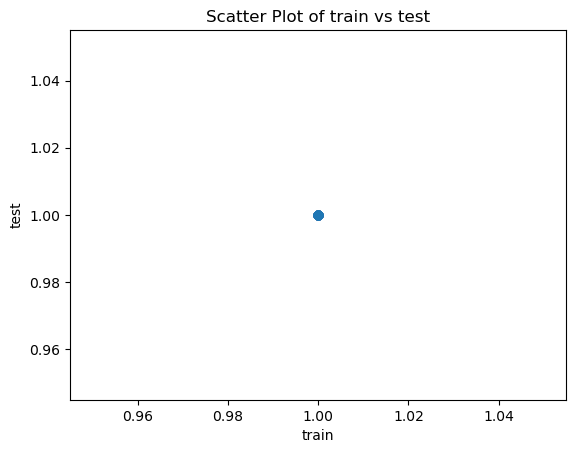

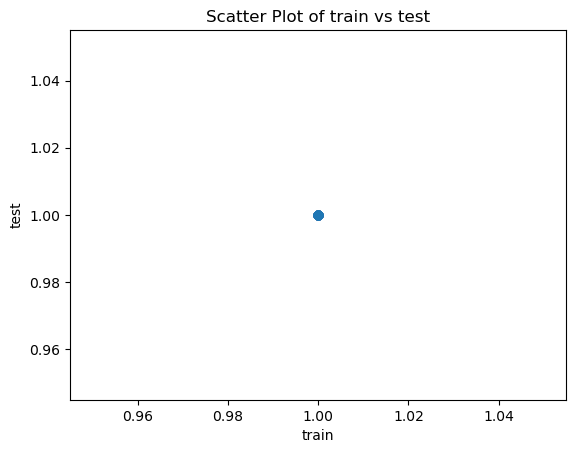

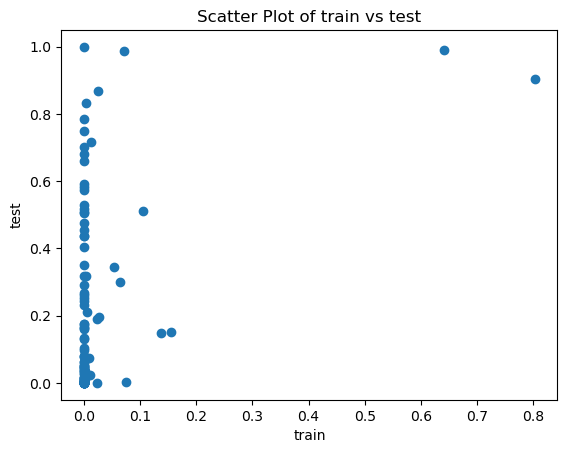

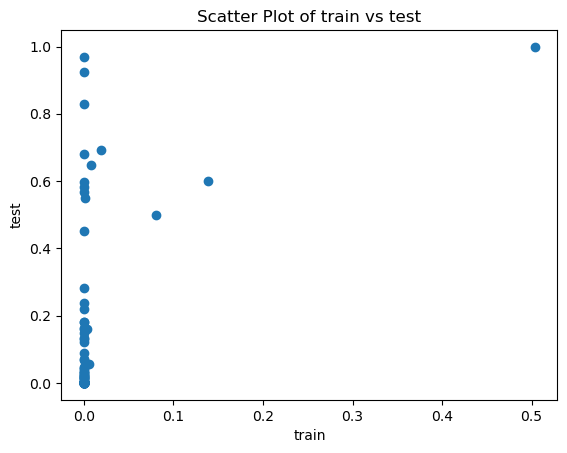

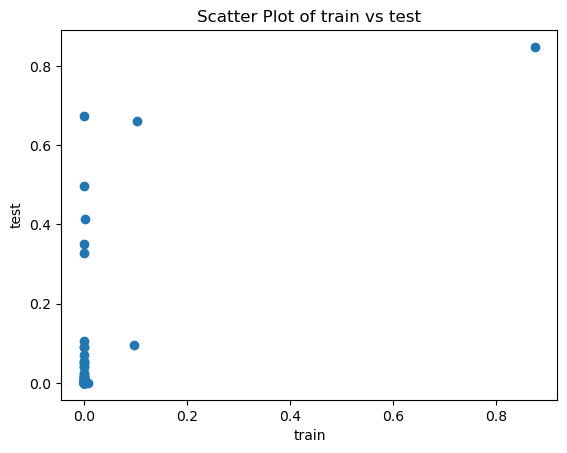

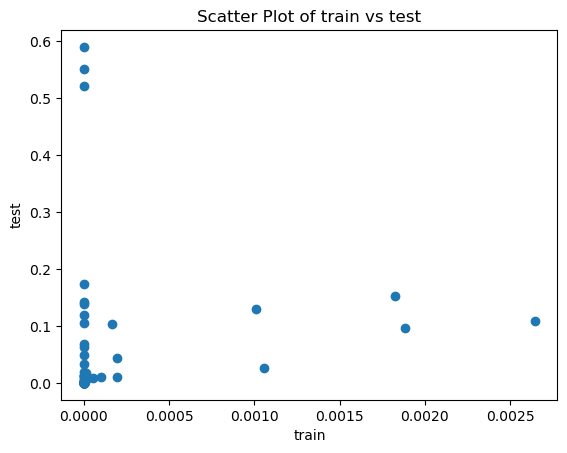

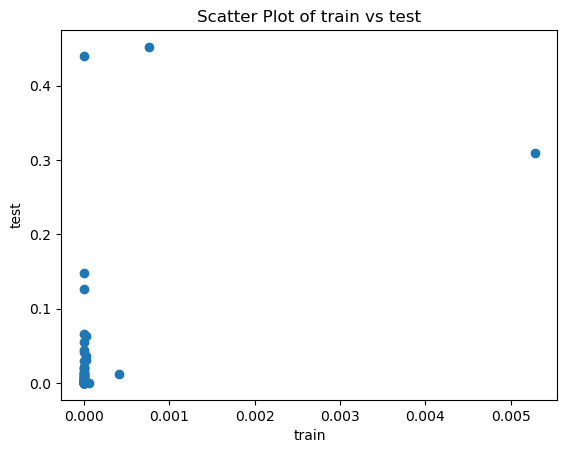

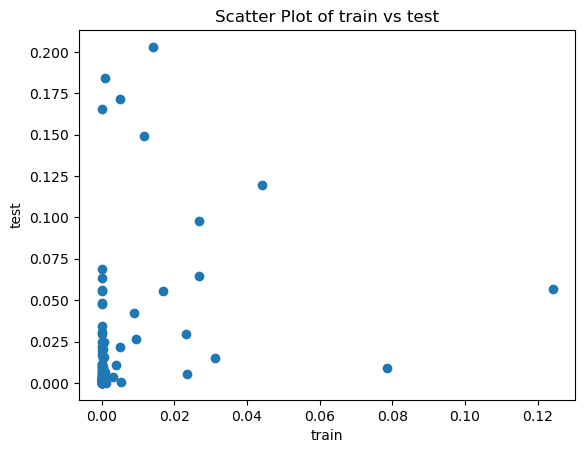

In [12]:
from Core.PS import PS
import random


def make_ps_of_size(size):
    values = np.full(shape=250, fill_value=-1, dtype=int)
    indices = random.sample(range(250), k=size)
    values[indices] = 1
    return PS(values)

for size in [1, 2, 4, 8, 16, 32, 64, 128]:
    pss = [set(random.sample(range(250), k=size)) for _ in range(100)]
    
    xs = [train_consistency_and_sample(ps)[0] for ps in pss]
    ys = [test_consistency_and_sample(ps)[0] for ps in pss]
    
    utils.simple_scatterplot(xs=xs, ys=ys, x_label = "train", y_label = "test")


In [13]:
len(test_sPRef.get_matching_fitnesses_and_not_matching(results[0].solution, threshold=3)[0])

2695

In [14]:
print(best_pattern)
old_best = {3, 4, 6, 9, 16, 24, 27, 37, 42, 43, 49, 52, 55, 65, 66, 67, 70, 75, 76, 82, 85, 86, 94, 96, 100, 103, 105, 109, 111, 117, 126, 129, 133, 145, 146, 156, 159, 163, 166, 170, 173, 174, 178, 183, 185, 187, 191, 202, 204, 212, 216, 220, 223, 224, 228, 231, 233, 235, 238, 241, 247, 248}


print(f"{len(best_pattern.intersection(old_best))}")
print(f"{len(best_pattern.union(old_best))}")

{2, 137, 138, 13, 143, 146, 20, 156, 157, 38, 41, 45, 174, 47, 48, 49, 59, 63, 192, 65, 195, 68, 198, 71, 200, 73, 204, 77, 79, 210, 212, 216, 89, 220, 224, 96, 100, 103, 109, 238, 242, 245, 248, 122}
16
90
